In [3]:
using PyPlot
using LowRankApprox
using DataFrames
using Roots
using Distributions

In [4]:
Y = Array{Float64,2}(readtable("EQTLSumStats_strong.txt", header = false));
include("ash.jl");
include("ash2.jl");
include("mixSQP.jl");
include("update_functions.jl");

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #readtable#229(::Bool, ::Char, ::Array{Char,1}, ::Char, ::Array{String,1}, ::Array{String,1}, ::Array{String,1}, ::Bool, ::Int64, ::Array{Symbol,1}, ::Array{Any,1}, ::Bool, ::Char, ::Bool, ::Int64, ::Array{Int64,1}, ::Bool, ::Symbol, ::Bool, ::Bool, ::DataFrames.#readtable, ::String) at /Users/yosikim/.julia/v0.6/DataFrames/src/deprecated.jl:1045
 [3] (::DataFrames.#kw##readtable)(::Array{Any,1}, ::DataFrames.#readtable, ::String) at ./<missing>:0
 [4] include_string(::String, ::String) at ./loading.jl:522
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/yosikim/.julia/v0.6/IJulia/src/execute_request.jl:158
 [6] (::Compat.#inner#18{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /Users/yosikim/.julia/v0.6/Compat/src/Compat.jl:378
 [7] eventloop(::ZMQ.Socket) at /Users/yosikim/.julia/v0.6/IJulia/src/eventloop.jl:8
 [8] (::IJulia.##14#17)() at ./task.jl:335
while loading In[4], in e

In [5]:
function spca(X; iter = 100, init = "by_svd",
              precision_type = "rowwise_constant",
              return_type = "posterior_mean",
              nv = 20, nullprior = 20,
              convtol = 1e-8,
              verbose = true)
    # initialize
    n,p = size(X);
    if init == "by_svd"
        temp = svds(X, nsv = 1)[1];
        u = temp[:U] * sqrt(n); u2 = u.^2;
        v = temp[:V] * temp[:S] / sqrt(n); v2 = v.^2;
    elseif init == "by_random"
        u = randn(n); u = u/norm(u); v = X'*u; u2 = u.^2; v2 = v.^2;
    else
        error("Error")
    end
    X2 = X.^2; i = 0; temp = 0;
    R2 = update_R2(X, X2, u, u2, v, v2);
    tau = update_tau(R2, precision_type);
    
    # loop start
    for i = 1:iter
        
        v_old = v/norm(v);
        
        # update u
        u, u2 = update_u(X, tau, v, v2, precision_type);
        
        # update v
        temp = update_v(X, tau, u, u2, precision_type, nv, nullprior; alpha = 1);
        
        if temp[:flag] == 1
            println("terminate the algorithm since ash solution is a vector of zero entries.")
            break;
        end
        
        v = temp[:pm]; v2 = temp[:pm2];
        
        # update tau
        R2 = update_R2(X, X2, u, u2, v, v2)
        tau = update_tau(R2, precision_type)
        
        a = norm(v); b = norm(v/norm(v) - v_old);
        if b < convtol
            @printf "iter %2d done: norm(v) = %1.3f and error %0.2e\n" i a b
            break;
        end
        
        if verbose == true && rem(i,100) == 0
            @printf "iter %2d done: norm(v) = %1.3f and error %0.2e\n" i a b
        end

    end
    
    out = Dict([
                (:u, u), (:u2, u2), (:v, v), (:v2, v2), (:tau, tau), (:temp, temp), (:iter, i)
                ])
    
    if return_type == "posterior_median"
        v_med = compute_posterior_median(temp);
        out[:v_med] = v_med;
    end
    
    return out
end

function compute_posterior_median(temp)
    
    # redefine
    x = temp[:x]; comp_post_prob = temp[:cpp];
    comp_post_mean = temp[:cpm]; comp_post_sd2 = temp[:cps2];
    
    ind = find(comp_post_prob[:,1] .< 0.5);
    post_median = zeros(length(x));
    for i in ind
        a = comp_post_prob[i,2:end];
        b = comp_post_mean[i,2:end];
        c = comp_post_sd2[i,2:end];
        d = comp_post_prob[i,1];
        
        # post_cdf
        function post_cdf(x)
            return a' * erfc.((x - abs.(b))./sqrt.(2*c)) + d - 0.5
        end
        post_median[i] = fzero(post_cdf,-1,1e2) * sign(x[i]);
    end
    return post_median
end

compute_posterior_median (generic function with 1 method)

In [123]:
X = copy(Y); precision_type = "columnwise_constant"; nv = 10; nullprior = 20;
n,p = size(X);
temp = svds(X, nsv = 1)[1];
        u = temp[:U] * sqrt(n); u2 = u.^2;
        v = temp[:V] * temp[:S] / sqrt(n); v2 = v.^2;
X2 = X.^2; i = 0; temp = 0;
    R2 = update_R2(X, X2, u, u2, v, v2);
    tau = update_tau(R2, precision_type);
v_old = v/norm(v);
        
        # update u
        u, u2 = update_u(X, tau, v, v2, precision_type);
s2 = 1./ (tau' * sum(u2));
   x = ((X .* tau)' * u) .* s2;

In [19]:
k_max = 20; n,p = size(Y); R = copy(Y);#Y .- mean(Y,1);
loading = zeros(n,k_max); factor = zeros(p,k_max);
for iter = 1:k_max
    if iter > 1
        R = R - loading[:,iter-1] * factor[:,iter-1]';
    end
    out = spca(R, iter = 1000, nv = 10, convtol = 1e-5, nullprior = 1000,
           init = "by_svd",
           return_type = "posterior_median",
           precision_type = "columnwise_constant",
           verbose = true);
    loading[:,iter] = out[:u]; factor[:,iter] = out[:v_med]; i = out[:iter];
    print_with_color(:red,"fitting factor/loading $iter, done with iteration $i\n")
end

iter  5 done: norm(v) = 16.490 and error 5.44e-06
fitting factor/loading 1, done with iteration 5
iter 14 done: norm(v) = 3.206 and error 5.01e-06
fitting factor/loading 2, done with iteration 14
iter 100 done: norm(v) = 2.440 and error 7.83e-04
iter 200 done: norm(v) = 2.463 and error 5.53e-03
iter 237 done: norm(v) = 2.467 and error 8.33e-06
fitting factor/loading 3, done with iteration 237
iter 55 done: norm(v) = 2.031 and error 9.84e-06
fitting factor/loading 4, done with iteration 55
iter 100 done: norm(v) = 1.528 and error 9.34e-06
fitting factor/loading 5, done with iteration 100
iter 100 done: norm(v) = 1.802 and error 1.26e-04
iter 179 done: norm(v) = 1.803 and error 9.90e-06
fitting factor/loading 6, done with iteration 179
iter 100 done: norm(v) = 1.407 and error 4.48e-05
iter 110 done: norm(v) = 1.407 and error 8.96e-06
fitting factor/loading 7, done with iteration 110
iter 100 done: norm(v) = 1.922 and error 1.29e-05
iter 104 done: norm(v) = 1.922 and error 9.87e-06
fittin

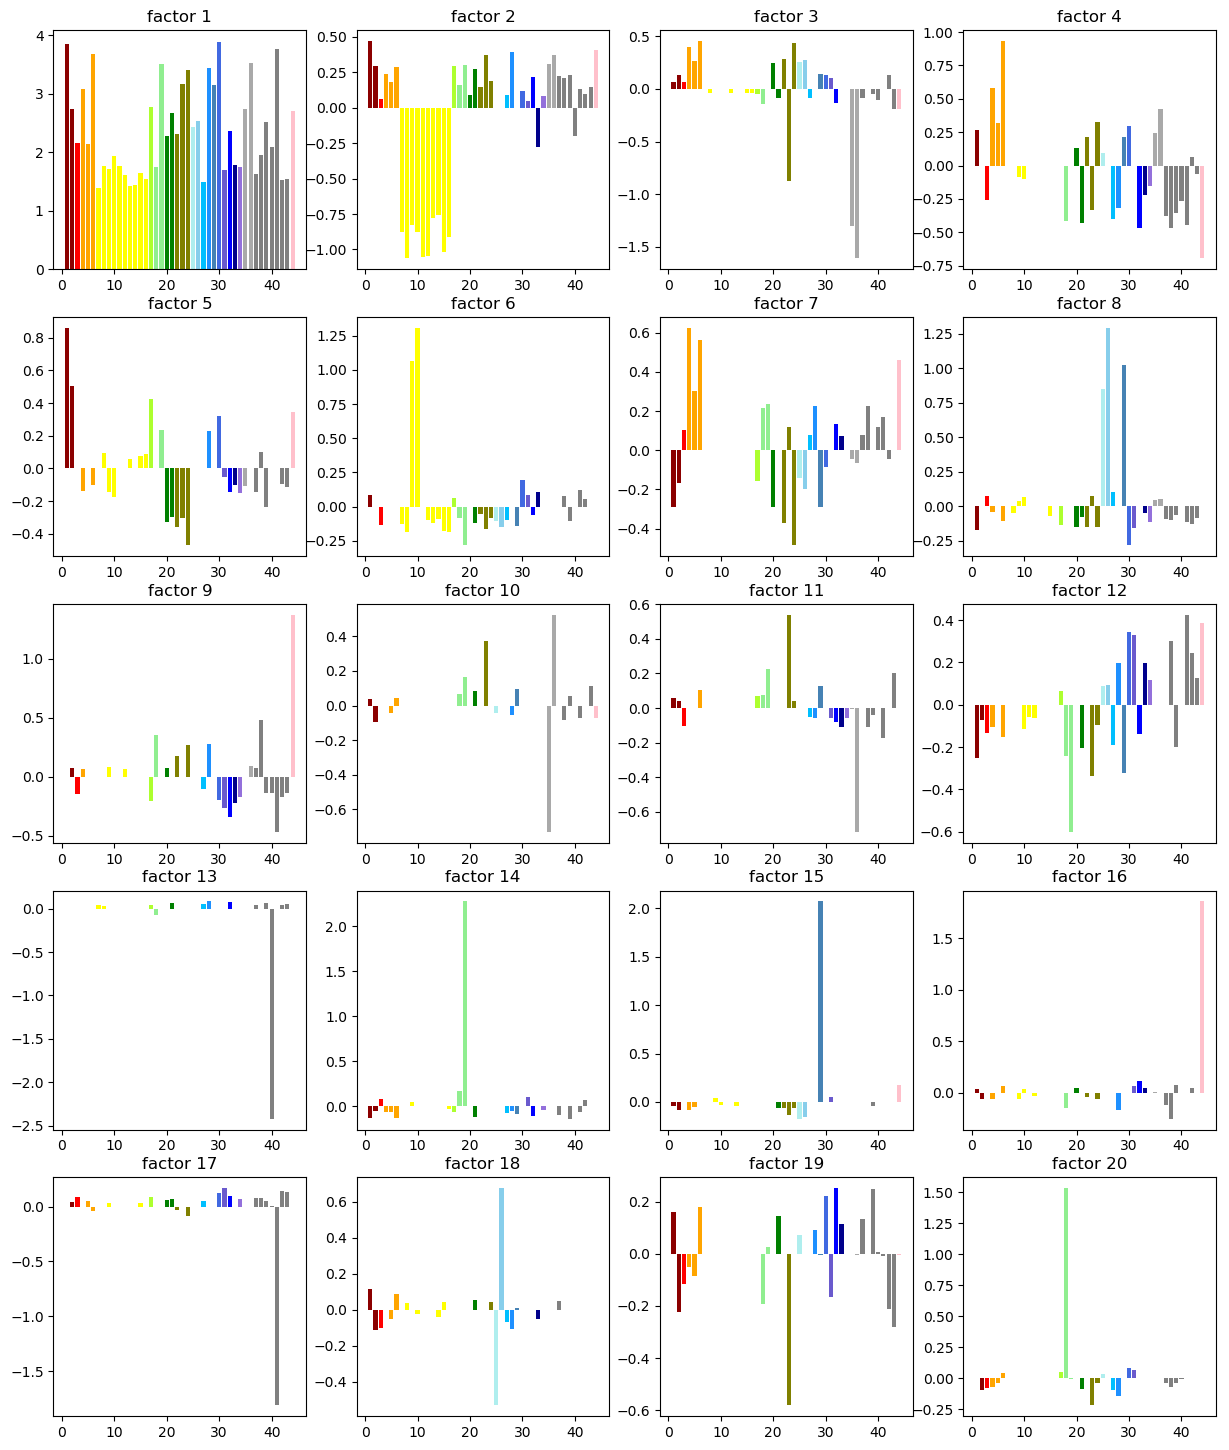

In [20]:
col =  [:darkred; :darkred; :red; :orange; :orange; :orange; repeat([:yellow], inner = 10);
        :greenyellow; :lightgreen; :lightgreen; :green; :green; :olive; :olive; :olive;
        :paleturquoise; :skyblue; :deepskyblue; :dodgerblue; :steelblue; :royalblue; :slateblue; :blue;
        :darkblue; :mediumpurple; :darkgray; :darkgray; repeat([:gray], inner = 7); :pink]
fig, ax = subplots(5,4, figsize = (15,18))
for i = 1:20
    subplot(5,4,i);
    bar(1:44, factor[:,i], color = col);
    title("factor $i")
end
savefig("F1.pdf")

In [9]:
k_max = 10; Z = Y'; n,p = size(Z); R = Z .- mean(Z,2);
loading = zeros(n,k_max); factor = zeros(p,k_max);
for iter = 1:k_max
    if iter > 1
        R = R - loading[:,iter-1] * factor[:,iter-1]';
    end
    out = spca(R, iter = 1000, nv = 10, convtol = 1e-4, nullprior = 10000,
           init = "by_svd",
           return_type = "posterior_median",
           precision_type = "columnwise_constant",
           verbose = true);
    loading[:,iter] = out[:u]; factor[:,iter] = out[:v_med]; i = out[:iter];
    print_with_color(:red,"$iter-th factor/loading done with iteration $i\n")
end

1-th factor/loading done with iteration 4
50-th iteration done with norm(v) = 41.56790905920702 and error 0.0001338515447833588
2-th factor/loading done with iteration 54
50-th iteration done with norm(v) = 30.41985068834759 and error 0.0004466065117046811
3-th factor/loading done with iteration 68
50-th iteration done with norm(v) = 27.92744251039959 and error 0.00018013019727415963
4-th factor/loading done with iteration 66
50-th iteration done with norm(v) = 27.3072972390877 and error 0.0003252967169455952
5-th factor/loading done with iteration 62
6-th factor/loading done with iteration 38
7-th factor/loading done with iteration 29
8-th factor/loading done with iteration 40
50-th iteration done with norm(v) = 20.068749060719714 and error 0.0001614248894794202
9-th factor/loading done with iteration 62
10-th factor/loading done with iteration 43


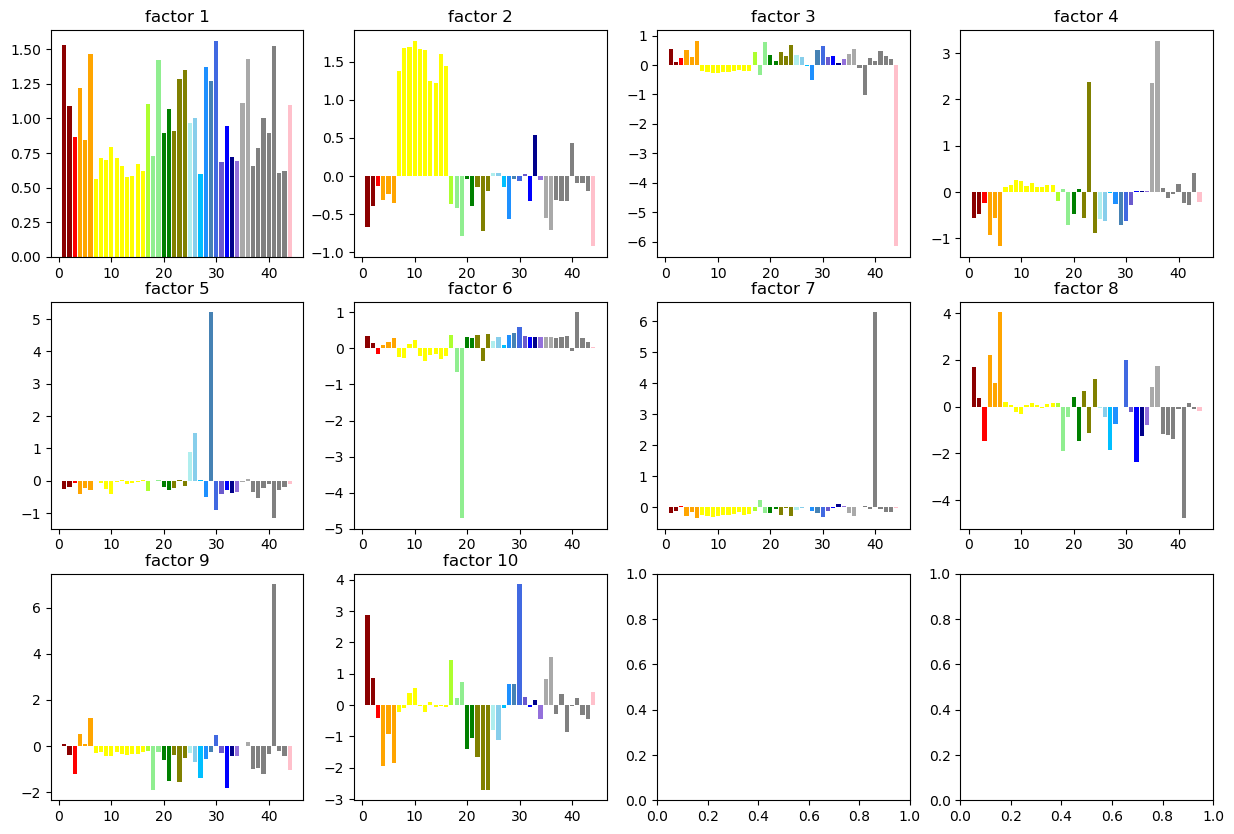

In [8]:
col =  [:darkred; :darkred; :red; :orange; :orange; :orange; repeat([:yellow], inner = 10);
        :greenyellow; :lightgreen; :lightgreen; :green; :green; :olive; :olive; :olive;
        :paleturquoise; :skyblue; :deepskyblue; :dodgerblue; :steelblue; :royalblue; :slateblue; :blue;
        :darkblue; :mediumpurple; :darkgray; :darkgray; repeat([:gray], inner = 7); :pink]
fig, ax = subplots(3,4, figsize = (15,10))
for i = 1:10
    subplot(3,4,i);
    bar(1:44, loading[:,i], color = col);
    title("factor $i")
end
savefig("F2.pdf")

In [202]:
k_max = 20; n,p = size(Y); R = Y .- mean(Y,1);
loading = zeros(n,k_max); factor = zeros(p,k_max);
for iter = 1:k_max
    if iter > 1
        R = R - loading[:,iter-1] * factor[:,iter-1]';
    end
    out = spca(R, iter = 500, nv = 12, convtol = 1e-5, nullprior = 20,
           init = "by_svd",
           return_type = "posterior_median",
           precision_type = "columnwise_constant",
           verbose = true);
    loading[:,iter] = out[:u]; factor[:,iter] = out[:v_med]; i = out[:iter];
    print_with_color(:red,"fitting factor/loading $iter, done with iteration $i\n")
end

iter  5 done: norm(v) = 16.466 and error 5.46e-06
fitting factor/loading 1, done with iteration 5
iter 12 done: norm(v) = 3.206 and error 5.85e-06
fitting factor/loading 2, done with iteration 12
iter 100 done: norm(v) = 2.442 and error 1.34e-03
iter 200 done: norm(v) = 2.469 and error 1.48e-04
iter 219 done: norm(v) = 2.469 and error 9.12e-06
fitting factor/loading 3, done with iteration 219
iter 58 done: norm(v) = 2.030 and error 9.22e-06
fitting factor/loading 4, done with iteration 58
iter 99 done: norm(v) = 1.532 and error 9.18e-06
fitting factor/loading 5, done with iteration 99
iter 100 done: norm(v) = 1.806 and error 1.22e-04
iter 179 done: norm(v) = 1.806 and error 9.82e-06
fitting factor/loading 6, done with iteration 179
iter 92 done: norm(v) = 1.417 and error 9.11e-06
fitting factor/loading 7, done with iteration 92
iter 100 done: norm(v) = 1.916 and error 9.77e-06
fitting factor/loading 8, done with iteration 100
iter 100 done: norm(v) = 1.996 and error 1.30e-02
iter 200 d

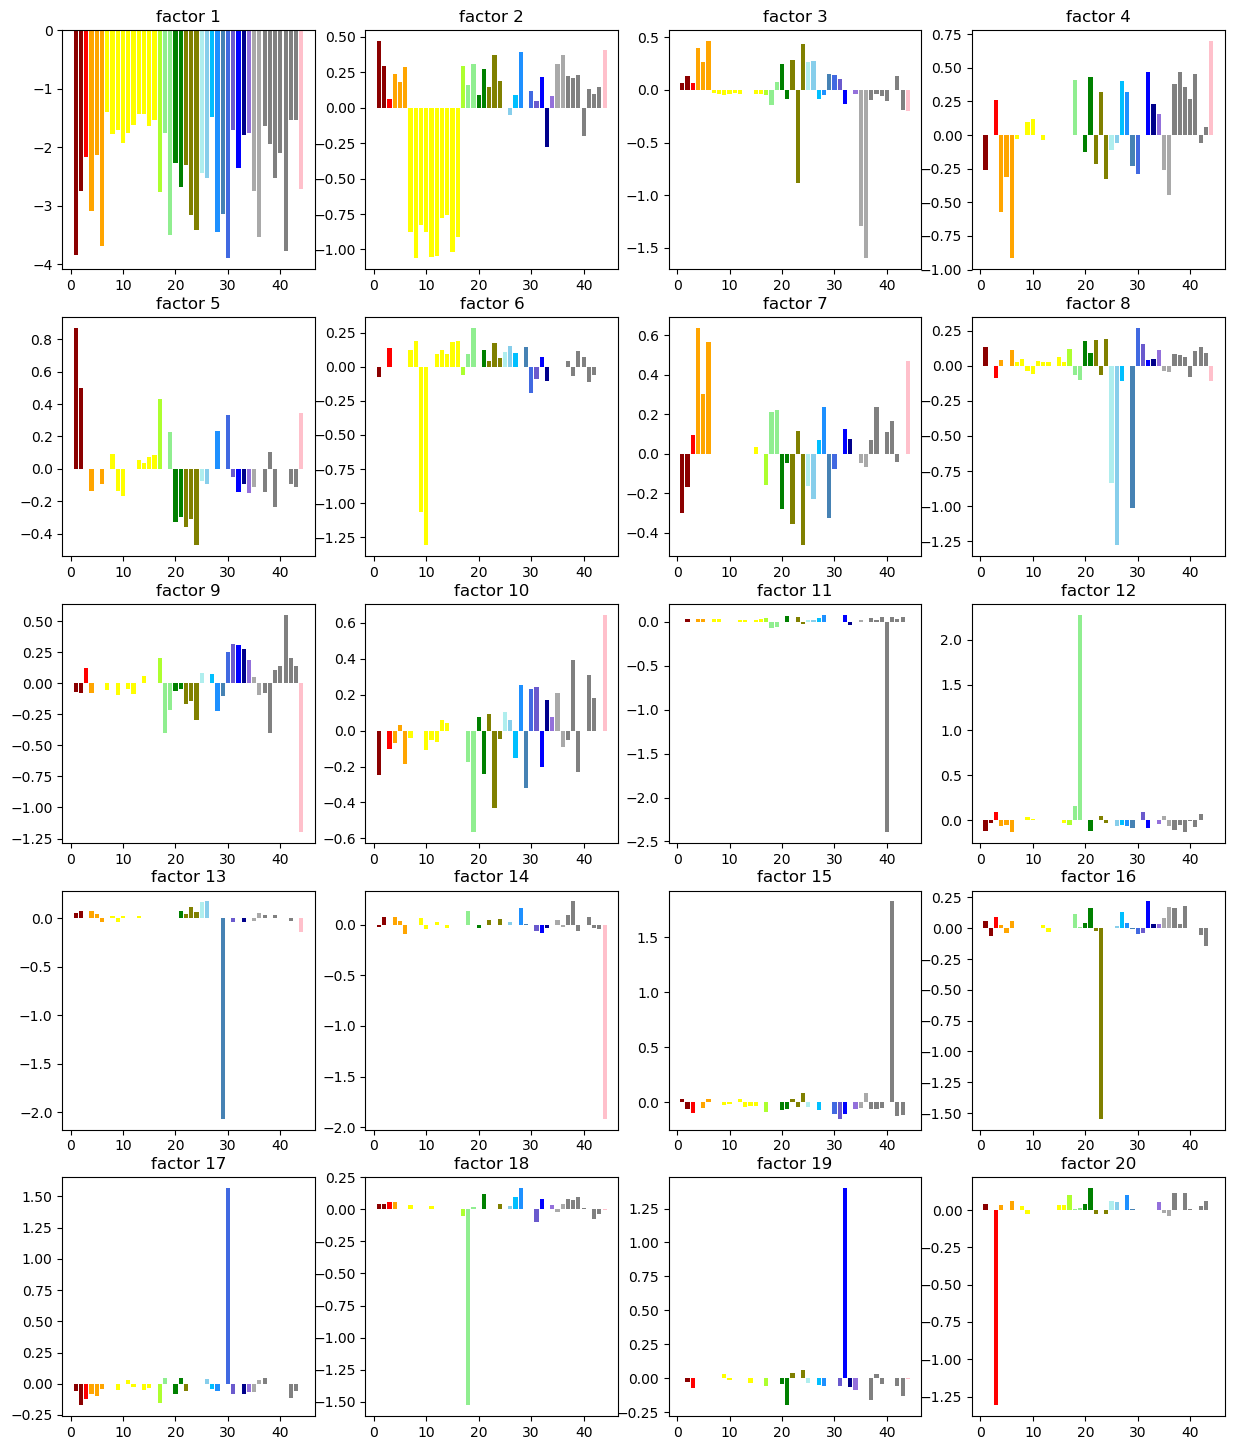

In [204]:
col =  [:darkred; :darkred; :red; :orange; :orange; :orange; repeat([:yellow], inner = 10);
        :greenyellow; :lightgreen; :lightgreen; :green; :green; :olive; :olive; :olive;
        :paleturquoise; :skyblue; :deepskyblue; :dodgerblue; :steelblue; :royalblue; :slateblue; :blue;
        :darkblue; :mediumpurple; :darkgray; :darkgray; repeat([:gray], inner = 7); :pink]
fig, ax = subplots(5,4, figsize = (15,18))
for i = 1:20
    subplot(5,4,i);
    bar(1:44, factor[:,i], color = col);
    title("factor $i")
end
savefig("F4.pdf")